# 情感分析：使用循环神经网络

| 变量               | 类型         | 作用                                            |
| ---------------- | ---------- | --------------------------------------------- |
| **`train_iter`** | DataLoader | 训练数据迭代器，每次返回 `(batch_features, batch_labels)` |
| **`test_iter`**  | DataLoader | 测试数据迭代器，用于模型评估                                |
| **`vocab`**      | Vocab      | 词汇表对象，提供词↔索引映射                                |


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 使用循环神经网络表示单个文本

In [2]:
class BiRNN(nn.Module):
    '''
    vocab_size：词汇表大小（如10002）
    embed_size：词嵌入维度（如100）
    num_hiddens：LSTM隐藏单元数量（如256）
    num_layers：LSTM层数（如2层）
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        # 1. 词嵌入层；将输入的词索引（如[12,85,7,...]）映射为稠密向量
        # 输出形状：(batch_size,seq_len,embed_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        '''
        2. 双向LSTM编码器
        bidirectional=True：启用双向LSTM
        正向LSTM：从左到右处理序列
        反向LSTM：从右到左处理序列
        输出包含两个方向的信息，能捕捉更完整的上下文
        '''
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        '''
        3. 全连接解码器
        输入维度4*num_hiddens 的含义：
        双向LSTM的最后一层输出4个张量：
        正向的隐藏状态（h）；正向的记忆单元（c）
        反向的隐藏状态（h）；反向的记忆单元（c）
        每个张量形状为(batch,num_hiddens)，拼接后得到(batch,4*num_hiddens)
        输出维度 2：对应二分类任务（0=负面，1=正面）
        '''
        self.decoder = nn.Linear(4 * num_hiddens, 2)
    '''
    输入索引: [64, 500] → 转置 → [500, 64]
        ↓ Embedding
    词向量: [500, 64, 100]
        ↓ 双向LSTM
    隐状态: [500, 64, 256*2] = [500, 64, 512]
        ↓ 取首尾拼接
    特征向量: [64, 512+512] = [64, 1024]  (4*256)
        ↓ Linear
    输出logits: [64, 2]
    '''
    def forward(self, inputs):
        '''
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        1. 输入处理与转置
        输入：inputs形状为(batch_size,seq_len)，例如 (64,500)，表示64条评论，每条500个词
        转置：.T使形状变为(seq_len,batch_size)，即(500,64)
        原因：PyTorch的LSTM要求第一个维度是时间步（seq_len）
        嵌入：转置后送入嵌入层，输出形状为 (seq_len,batch_size,embed_size)，例如 (500,64,100)
        '''
        embeddings = self.embedding(inputs.T)
        # 2. 优化参数存储:将LSTM的参数展平为连续内存块，提升计算效率
        self.encoder.flatten_parameters()
        '''
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        3. 双向LSTM编码
        输入：嵌入张量(500,64,100)
        输出：
        outputs：形状为 (seq_len,batch_size,2*num_hiddens)，如 (500,64,512)
        双向LSTM每个时间步输出前向和反向两个方向的隐藏状态，拼接后维度翻倍
        _：忽略了(h_n,c_n)最终状态（因为后续使用outputs的首尾时间步已经足够）
        '''
        outputs, _ = self.encoder(embeddings)
        '''
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        4. 关键特征提取（首尾拼接）
        outputs[0]：第一时间步的隐状态，形状(batch_size,2*num_hiddens)，如(64,256),包含序列开头的双向上下文信息
        outputs[-1]  ：最后时间步的隐状态，形状同样是(batch_size,2*num_hiddens),包含序列末尾的双向上下文信息
        拼接：在维度1上拼接，得到 (batch_size,4*num_hiddens)，如(64,512);捕捉了整个序列的首尾综合特征
        '''
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # 5. 分类输出,encoding传入全连接层self.decoder
        # 输出：形状 (batch_size,2)，表示每个样本属于负面/正面的原始logits
        outs = self.decoder(encoding)
        return outs

让我们构造一个具有两个隐藏层的双向循环神经网络来表示单个文本以进行情感分析。


In [3]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

为什么需要手动初始化？
| 层类型    | 默认初始化                           | 问题           | Xavier的优势     |
| ------ | ------------------------------- | ------------ | ------------- |
| Linear | 均匀分布 `U[-1/sqrt(k), 1/sqrt(k)]` | 范围固定，不适应不同维度 | 动态调整范围，保持方差稳定 |
| LSTM   | 同上                              | 门控机制敏感，易梯度消失 | 更稳定的训练启动      |


In [4]:
# 参数m：传入的神经网络层（如Linear、LSTM等）
def init_weights(m):
    '''
    全连接层初始化
    检测：判断模块是否为nn.Linear（全连接层）
    初始化：对权重矩阵m.weight使用Xavier均匀分布初始化
    作用：根据输入/输出维度自动调整初始化范围，避免梯度消失/爆炸
    原理：权重从[-a,a]的均匀分布中采样，其中a=sqrt(6/(fan_in+fan_out))
    '''
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    '''
    LSTM层初始化
    检测：判断模块是否为nn.LSTM
    遍历参数：m._flat_weights_names 包含LSTM所有展平后的参数名（如weight_ih_l0、weight_hh_l0等）
    筛选权重：只初始化含"weight"的参数（跳过bias偏置项）
    统一初始化：对LSTM的所有权重矩阵同样使用Xavier初始化
    '''
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
'''
应用初始化
net.apply()：递归地将init_weights函数应用到net的每个子模块
自动遍历：会遍历网络中所有的Linear和LSTM层（包括嵌套结构）
执行顺序：从浅层到深层依次初始化
'''
net.apply(init_weights);

## 加载预训练的词向量

下面，我们为词表中的单词加载预训练的100维（需要与`embed_size`一致）的GloVe嵌入。


| 部分          | 含义                                  |
| ----------- | ----------------------------------- |
| **`glove`** | 使用**GloVe**算法训练的词向量                 |
| **`6b`**    | 在**60亿个词元**（6 billion tokens）的语料上训练 |
| **`100d`**  | 每个词向量的维度为 **100维**                  |


In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

打印词表中所有词元向量的形状。


In [6]:
'''
1. vocab.idx_to_token是一个列表，按索引顺序包含词汇表中的所有词元
例如：['<unk>','<pad>','the','a','and','of','to','is',...];长度=len(vocab)
2. glove_embedding[...]
批量查询：将词汇表中的所有词一次性输入GloVe对象
返回值：一个形状为(词汇表大小,100)的张量
每行对应一个词元的100维GloVe向量
行顺序与vocab.idx_to_token列表完全一致
'''
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

我们使用这些预训练的词向量来表示评论中的词元，并且在训练期间不要更新这些向量。


In [7]:
'''
复制预训练权重
1. net.embedding.weight：访问模型的嵌入层权重矩阵；形状：(vocab_size,embed_size)
初始值：随机初始化或默认初始化
2. .data.copy_(embeds)：原地复制预训练向量
embeds是之前从GloVe提取的权重矩阵(10002,100)
逐元素替换：将模型嵌入层的权重替换为GloVe预训练向量
<pad>等特殊词元可能对应零向量或随机向量
效果：模型现在使用GloVe预训练的语义表示作为起点，而非随机初始化。
'''
net.embedding.weight.data.copy_(embeds)
'''
冻结权重（关键决策）
requires_grad=False：关闭梯度计算
反向传播时不计算该权重的梯度
优化器不更新这些参数
训练过程中保持GloVe原始向量不变
'''
net.embedding.weight.requires_grad = False

## 训练和评估模型

现在我们可以训练双向循环神经网络进行情感分析。


loss 0.287, train acc 0.880, test acc 0.855
1917.3 examples/sec on [device(type='cuda', index=0)]


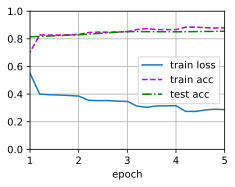

In [8]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

我们定义以下函数来使用训练好的模型`net`预测文本序列的情感。


In [9]:
'''
输入文本: "this movie is great"
    ↓ split()
词元列表: ['this', 'movie', 'is', 'great']
    ↓ vocab[...]
索引张量: tensor([12, 85, 7, 33])
    ↓ reshape(1, -1)
输入模型: tensor([[12, 85, 7, 33]])  # 形状 (1, 4)
    ↓ net()
输出logits: tensor([[2.1, 5.8]])     # 形状 (1, 2)
    ↓ argmax(dim=1)
预测类别: tensor([1])
    ↓ 映射
最终结果: 'positive'
'''
#@save
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    '''
    1. 词元转索引
    sequence.split()：将输入字符串按空格分割成单词列表
    例如："this movie is great"→['this','movie','is','great']
    vocab[...]：将每个单词映射为词汇表中的索引
    例如：[12,85,7,33]（不在词表的词会被映射为<unk>的索引）
    torch.tensor(...)：转换为PyTorch张量
    device=d2l.try_gpu()：自动将数据移到GPU（如果可用），加速推理
    '''
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    '''
    2. 模型推理
    sequence.reshape(1,-1)：调整形状为 (1,seq_len)，添加批次维度;例如：若原序列长度=8，则形状变为 (1,8)
    net(...)：传入模型，得到输出logits，形状 (1,2)
    两个值分别代表"负面"和"正面"的未归一化分数
    torch.argmax(...,dim=1)  ：在维度1上找最大值索引，得到预测类别
    返回形状(1,) 的张量，值为0（负面）或1（正面）
    '''
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    # 3. 结果映射:类别映射：label==1→'positive'（正面）;label==0→'negative'（负面）
    return 'positive' if label == 1 else 'negative'

最后，让我们使用训练好的模型对两个简单的句子进行情感预测。


In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'